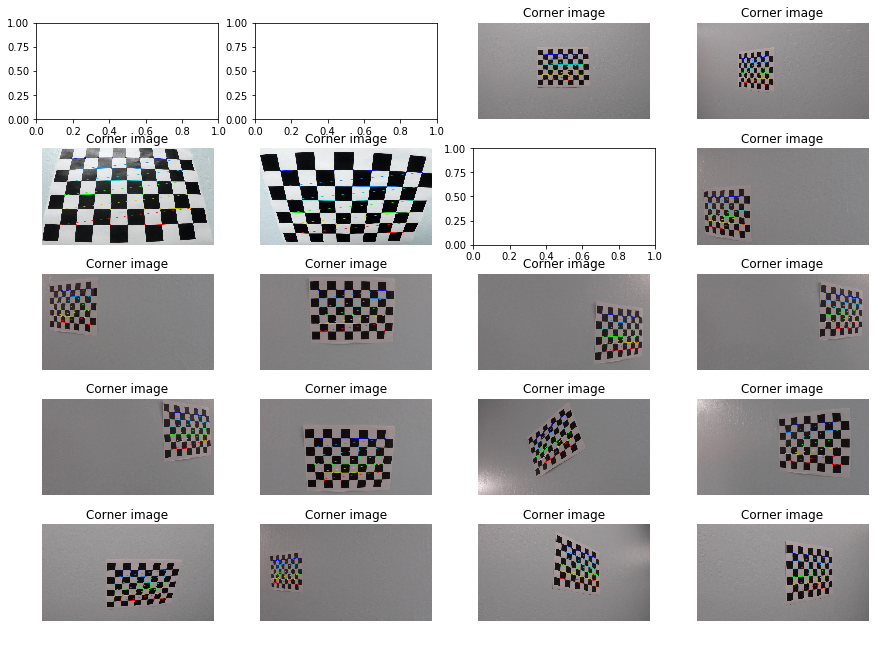

In [2]:
# Camera Calibration matrix and distortion coefiicients 
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

# Arrays to store object points and image points from all the images
objPoints = []
imgPoints = []
 
# prepare object points 
objP = np.zeros((6*9,3), np.float32)
objP[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) #x, y coordinates

fig, axs = plt.subplots(5, 4, figsize=(15,11))
fig.subplots_adjust(hspace = 0.3)

axs = axs.ravel()
imgContainer = glob.glob('camera_cal/*.jpg')

for i, index in enumerate(imgContainer):
    image = cv2.imread(index)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    # if corners are found, add object points, image points
    if ret == True:
        imgPoints.append(corners)
        objPoints.append(objP)
        
        img = cv2.drawChessboardCorners(image, (9,6), corners, ret)
        axs[i].axis('off')
        axs[i].imshow(img)
        axs[i].set_title('Corner image')

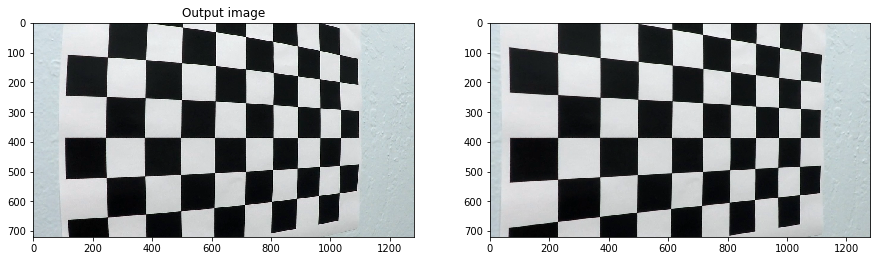

In [28]:
# these individual implementation steps are being followed from the lectures series
# undistortion
img = cv2.imread('./camera_cal/calibration5.jpg')
img_shape = (img.shape[1], img.shape[0])

# Camera Calibration, shape of the grayScale image
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, img_shape, None, None)

# undistorting an image
dst = cv2.undistort(img, mtx, dist, None, mtx)

# plotting the source and calbrated image
fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(15,11))
axs1.set_title('Given image')
axs1.imshow(img)
axs1.set_title('Output image')
axs2.imshow(dst)
